# Проект: Закономерности, определяющие успешность игры

Интернет-магазине «Стримчик» продаёт по всему миру компьютерные игры. Магазину необходимо спланировать рекламную компанию потенциально популярного продукта. Так же необходимо выделить популярные игровые платформы и жанры. Проверить, влияет ли возрастной рейтинг продукта на продажи в отдельном регионе.

Проверите некоторые гипотезы:
 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
 - Средние пользовательские рейтинги жанров Action и Sports разные.

Данные для исследования получены из открытых источников, исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).




<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Для построения пузырьковой диаграммы необходимо установить библиотеку `circlify`, она весит 11Кб
</div>

In [1]:
pip install circlify

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import circlify
from scipy import stats as st

In [3]:
pd.set_option('max_columns', None)

## Шаг. Откройте файл с данными и изучите общую информацию

In [4]:
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [5]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [7]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [8]:
data['User_Score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.5       2
2.3       2
0.5       2
0         1
9.7       1
Name: User_Score, Length: 96, dtype: int64

Полученные данные имеют 16'715 записей и 11 параметров. Список парамтеров:
 - Name — название игры
 - Platform — платформа
 - Year_of_Release — год выпуска
 - Genre — жанр игры
 - NA_sales — продажи в Северной Америке (миллионы проданных копий)
 - EU_sales — продажи в Европе (миллионы проданных копий)
 - JP_sales — продажи в Японии (миллионы проданных копий)
 - Other_sales — продажи в других странах (миллионы проданных копий)
 - Critic_Score — оценка критиков (максимум 100)
 - User_Score — оценка пользователей (максимум 10)
 - Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

После первичного просмотра данных мы видим, что есть и пропущенные данные (где-то совсем много "Оценка критиков, "Оценка пользователей" и "возрастной рейтинг"), часть данных имеет неправлиьный размер - дата в формате числа с плавающей точкой. Для параметра "Оценка пользователей" есть много значений "tbd", исследуем их ниже

Видим, что данные собраны по играм, начинаея с 1980г по 2016г.

## Шаг. Подготовьте данные

### Заменим названия столбцов (приведем к нижнему регистру)

In [9]:
data.columns = data.columns.str.lower()

### Обработка пропусков

In [10]:
data.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

#### Название игры

In [11]:
data[data['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Игры без названия удаляем

In [12]:
data = data.dropna(subset=['name'])

#### Дата релиза

In [13]:
data[data['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Удалим данные по платформам, актуальным до 2014 года

In [14]:
data = data.query('year_of_release.notnull() or year_of_release.isnull() and platform not in ("Wii", "DS", "XB", "2600", "GC", "GBA", "PS", "PS2", "N64", "GB")')

Какие-то данные по году выпуска можно взять из названия игры, остальные данные заменим на 0

Функция для поиска даты релиза по названию игры. Если не находим дату в конце названия игры, то ~указываем ноль~ ничего не делаем

In [15]:
def find_year(x):
    try:
        if pd.isna(x['year_of_release']):
            if x['name'][-4:].isdigit():
                x['year_of_release'] = int(x['name'][-4:])
        return x
    
    except:
        return x

In [16]:
print(f"""Проверим, нет ли в списке игр, каких-нибудь Anno или Киберпанка с аномально большими или малыми значениями:
min={min(data[data['year_of_release'] != 0]['year_of_release'])}, max={max(data['year_of_release'])}""")

Проверим, нет ли в списке игр, каких-нибудь Anno или Киберпанка с аномально большими или малыми значениями:
min=1980.0, max=2016.0


In [17]:
data = data.apply(find_year, axis=1)

In [18]:
print(f"Осталось {len(data[data['year_of_release'].isnull()])} пустых значений, на платформах:")
data[data['year_of_release'].isnull()]['platform'].value_counts()

Осталось 94 пустых значений, на платформах:


X360    28
PS3     25
PC      17
PSP     15
3DS      8
PSV      1
Name: platform, dtype: int64

In [19]:
data[data['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
1131,Call of Duty: Black Ops,PC,NaN,Shooter,0.58,0.81,0.00,0.23,81.0,5.2,M
1142,Rock Band,PS3,NaN,Misc,0.99,0.41,0.00,0.22,92.0,8.4,T
1538,LEGO Batman: The Videogame,PSP,NaN,Action,0.57,0.44,0.00,0.27,73.0,7.4,E10+
2132,LEGO Harry Potter: Years 5-7,X360,NaN,Action,0.51,0.37,0.00,0.09,77.0,7.9,E10+
...,...,...,...,...,...,...,...,...,...,...,...
16293,AKB1/48: Idol to Guam de Koishitara...,X360,NaN,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16329,Brothers in Arms: Furious 4,X360,NaN,Shooter,0.01,0.00,0.00,0.00,NaN,NaN,M
16348,Agarest Senki: Re-appearance,PS3,NaN,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M


In [20]:
print(f"Данные после обработки: min={min(data[data['year_of_release'] != 0]['year_of_release'])}, \
max={max(data['year_of_release'])}")

Данные после обработки: min=1980.0, max=2016.0


Аномальных данных не получили

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Стоит посмотреть на платформы, к которым относятся пропуски из колонки год выпуска игры, и с легкостью расстанешься с ними ... более 99% данных принадлежит устаревшим платформам и могут быть удалены сразу
        
Рекомендуется прежде чем, выполнять проект минут 15-30 посвятить теме анализа (поиску в интернете — что происходит в игровом мире, каким образом развивается рынок ...), чтобы уверенно плавать в океане противоречивых данных :)

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Исправил. Правда 99% я не нашёл, но где-то 2/3 пропусков убралось
        
        

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />99% из 269 пропусков в записях принадлежит устаревшим платформам

Заменим пропуски на нули

In [21]:
data['year_of_release'].fillna(0, inplace=True)

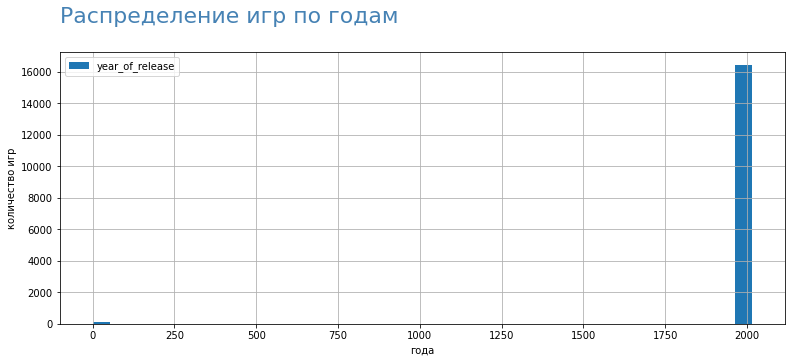

In [22]:
data.plot(
    kind='hist',
    y='year_of_release',
    histtype='bar',
    bins=data['year_of_release'].nunique()+1,
    grid=True,
    figsize=(13,5)
);

plt.title('Распределение игр по годам' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
plt.xlabel("года")
plt.ylabel("количество игр");

In [23]:
data['year_of_release'] = data['year_of_release'].astype('int')

In [24]:
print(f"""Количество игр, у которых не смогли найти год: {len(data[data['year_of_release'] == 0])}.
Возможно от таких данных придётся избавиться. 
Возможно ещё какую-то часть можно будет восстановить, если взять данные с других платформ, 
но это не всегда корректно, т.к. игра на разных поколениях консолей может выходить с разницей 5-10 лет. Как пример GTA5""")

Количество игр, у которых не смогли найти год: 94.
Возможно от таких данных придётся избавиться. 
Возможно ещё какую-то часть можно будет восстановить, если взять данные с других платформ, 
но это не всегда корректно, т.к. игра на разных поколениях консолей может выходить с разницей 5-10 лет. Как пример GTA5


#### Оценки пользователей

Посмотрим на уникальные значения оценок:

In [25]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Так как рейтинг ноль есть в списке, разберемся, что такое 'tbd'

**Аббревиатура 'tbd' в столбце с оценкой пользователей**

**Entertainment Software Rating Board (ESRB)** — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. ESRB была основана в **1994** году ассоциацией Interactive Digital Software Association (современное название — «Entertainment Software Association»). К началу 2003 года рейтинги ESRB получили более 8000 продуктов от 350 издателей. (Wiki)

**'tbd'** - означает, что рейтинг не указан. Можно приравнять такое значение к нулю, но вначале изучим данные

In [26]:
data[data['user_score'] == 'tbd'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E


In [27]:
print(f"Всего игр с рейтингом пользователей 'tbd': {len(data[data['user_score'] == 'tbd'])}")

Всего игр с рейтингом пользователей 'tbd': 2384


Заменим пропуски на 'tbd'

In [28]:
data['user_score'].fillna('tbd', inplace=True)

In [29]:
data[data['year_of_release'] != 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,tbd,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,tbd,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,tbd,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,tbd,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,tbd,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,tbd,NaN


Посмотрим, как происходит распределение всех оценок

In [30]:
data['user_score'].value_counts()

tbd    9019
7.8     322
8       288
8.2     279
8.3     253
       ... 
1.1       2
9.6       2
0.7       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

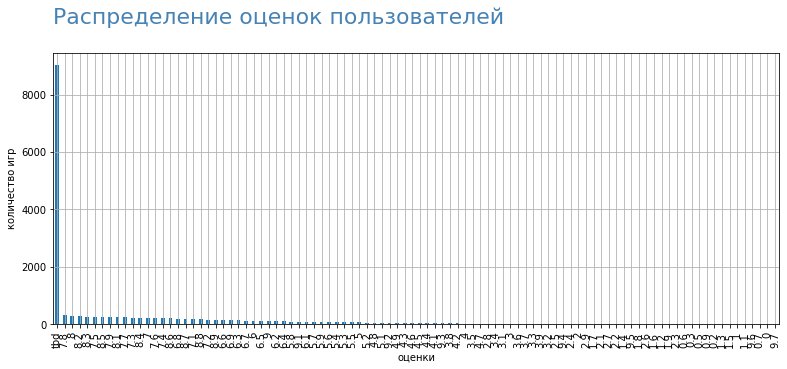

In [31]:
data['user_score'].value_counts().plot(
    kind='bar',
    grid=True,
    figsize=(13,5)
);

plt.title('Распределение оценок пользователей' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
plt.xlabel("оценки")
plt.ylabel("количество игр");

Очевидно, что 'tbd' очень много.

Посмотрим на распределение этой оценки по годам

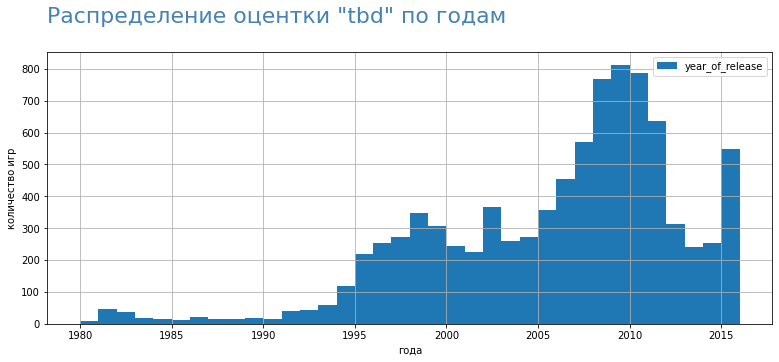

In [32]:
data[(data['user_score'] == 'tbd') & (data['year_of_release'] != 0)].plot(
    kind='hist',
    y='year_of_release',
    histtype='bar',
    bins=data[(data['user_score'] == 'tbd') & (data['year_of_release'] != 0)]['year_of_release'].nunique()-1,
    grid=True,
    figsize=(13,5)
);

plt.title('Распределение оцентки "tbd" по годам' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
plt.xlabel("года")
plt.ylabel("количество игр");

Пик игр без рейтинга (с рейтингом 'tbd') - 2009 год, видимо после этого года началось активное внедрения системы рейтинга ассоциации ESRB

Видно, что график претерпел небольшие изменения, но общий его вид остался таким же

Посмотрим продажи игр с таким рейтингом

In [33]:
data[data['user_score'] == 'tbd']['na_sales'].value_counts()

0.00     3789
0.02      344
0.03      315
0.04      301
0.01      299
         ... 
2.21        1
1.58        1
5.55        1
29.08       1
2.06        1
Name: na_sales, Length: 266, dtype: int64

In [34]:
data[data['user_score'] == 'tbd']['eu_sales'].value_counts()

0.00    4724
0.01     754
0.02     588
0.03     386
0.04     306
        ... 
1.34       1
2.35       1
1.22       1
1.01       1
1.71       1
Name: eu_sales, Length: 187, dtype: int64

In [35]:
data[data['user_score'] == 'tbd']['jp_sales'].value_counts()

0.00    4966
0.02     515
0.03     379
0.01     362
0.04     264
        ... 
2.65       1
1.21       1
2.26       1
1.28       1
1.71       1
Name: jp_sales, Length: 205, dtype: int64

In [36]:
data[data['user_score'] == 'tbd']['other_sales'].value_counts()

0.00    5114
0.01    1732
0.02     691
0.03     353
0.04     242
        ... 
0.32       1
0.76       1
0.47       1
0.81       1
0.66       1
Name: other_sales, Length: 88, dtype: int64

In [37]:
tbd_na_0 = data[data['user_score'] == 'tbd']['na_sales'].value_counts()[0] # Нулевые продажи в Северной Америке
tbd_eu_0 = data[data['user_score'] == 'tbd']['eu_sales'].value_counts()[0] # Нулевые продажи в Европе
tbd_jp_0 = data[data['user_score'] == 'tbd']['jp_sales'].value_counts()[0] # Нулевые продажи в Японии
tbd_ot_0 = data[data['user_score'] == 'tbd']['other_sales'].value_counts()[0] # Нулевые продажи в других странах

In [38]:
print(f"""Найдём кол-во игр с нулевыми продажами:
Продажи в Северной Америке: {tbd_na_0}
Продажи в Европе: {tbd_eu_0}
Продажи в Японии: {tbd_jp_0}
Продажи в других странах: {tbd_ot_0}
""")

Найдём кол-во игр с нулевыми продажами:
Продажи в Северной Америке: 3789
Продажи в Европе: 4724
Продажи в Японии: 4966
Продажи в других странах: 5114



In [39]:
tmp = {'Регион': ['Северная Америка', 'Европа', 'Япония', 'Др. страны'], 'Кол-во игр': [tbd_na_0, tbd_eu_0, tbd_jp_0, tbd_ot_0]}
tbd_barh = pd.DataFrame(data=tmp)
tbd_barh = tbd_barh.set_index('Регион')
tbd_barh = tbd_barh.sort_values(by='Кол-во игр')

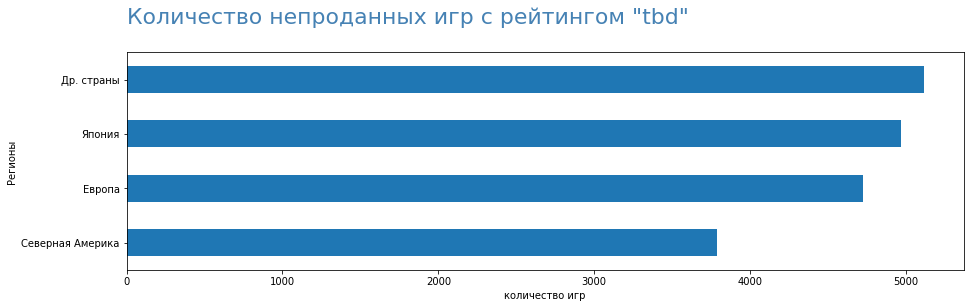

In [40]:
tbd_barh.plot.barh(figsize=(15,4), legend=False);

plt.title('Количество непроданных игр с рейтингом "tbd"' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
plt.xlabel("количество игр")
plt.ylabel("Регионы");

Отсеим нули и 'tbd' и посмотрим на распределение оценок

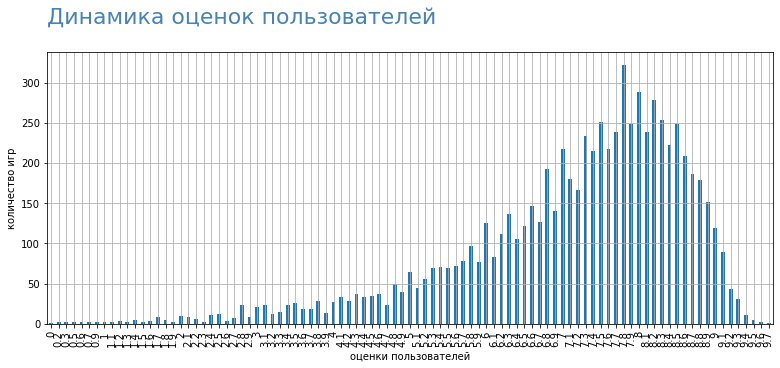

In [41]:
data[(data['user_score'] != 'tbd') & (data['user_score'] != 0)]['user_score'].value_counts().sort_index(ascending=True).plot(
    kind='bar',
    grid=True,
    figsize=(13,5)
);
plt.title('Динамика оценок пользователей' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
plt.xlabel("оценки пользователей")
plt.ylabel("количество игр");

Хороших игр - подавляющее большенство, как было бы хорошо, если бы сейчас рейтинги были бы показателями качества игры!

Посмотрим на распределение игр по жанру:

In [42]:
d_genre = data.pivot_table(index='genre', values='name', aggfunc='count')
d_genre = d_genre.sort_values(by='name')
d_genre

,name
genre,
Puzzle,571
Strategy,681
Fighting,839
Simulation,864
Platform,879
Racing,1235
Adventure,1296
Shooter,1307
Role-Playing,1487


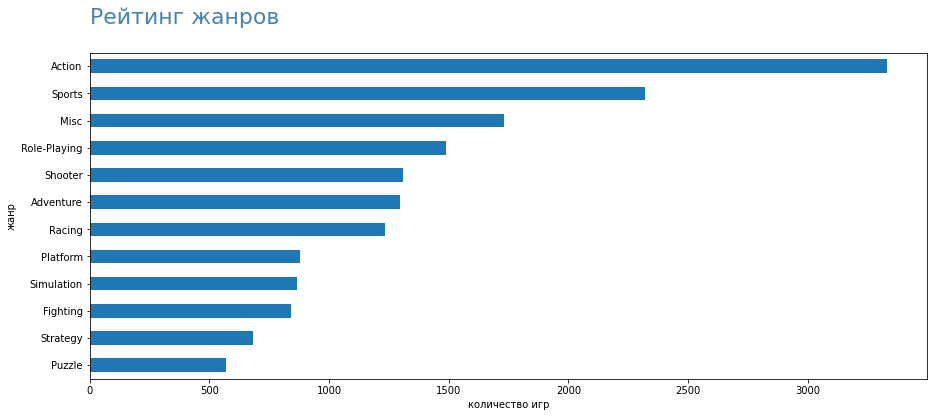

In [43]:
ax = d_genre.plot.barh(figsize=(15,6), legend=False)
ax.set_xlabel("количество игр")
ax.set_ylabel("жанр");
plt.title('Рейтинг жанров' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

Посмотрим, сколько игр в разных жанрах имеют рейтинг 0 или 'tbd'

In [44]:
d_genre_tbd = data[(data['user_score'] == 'tbd') | (data['user_score'] == 0)]. \
                                            pivot_table(index='genre', values='name', aggfunc='count')
d_genre_tbd = d_genre_tbd.sort_values(by='name')
d_genre_tbd

,name
genre,
Strategy,372
Shooter,392
Fighting,443
Puzzle,444
Platform,454
Simulation,522
Racing,599
Role-Playing,748
Adventure,997


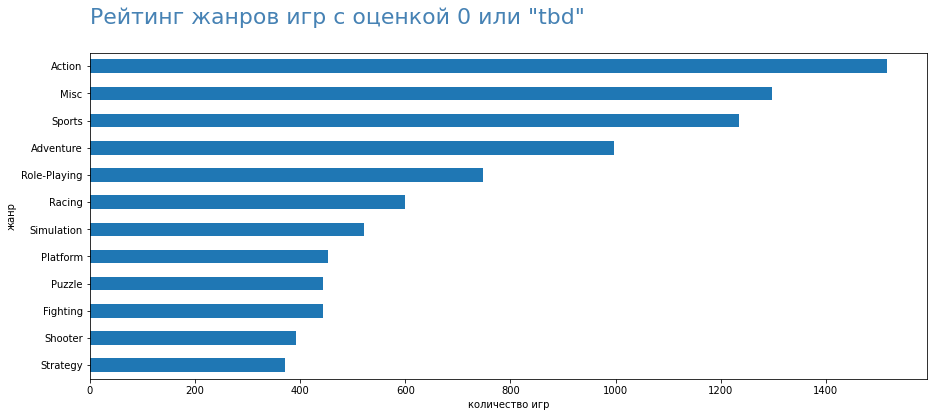

In [45]:
ax = d_genre_tbd.plot.barh(figsize=(15,6), legend=False)
ax.set_xlabel("количество игр")
ax.set_ylabel("жанр");
plt.title('Рейтинг жанров игр с оценкой 0 или "tbd"' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

In [46]:
print(f"Всего данных о продажах игр с рейтингом 0 и 'tbd': {round(len(data[(data['user_score'] == 'tbd') | (data['user_score'] == 0)]) / len(data) * 100)}% - это очень много. сколько данных удалять нельзя")

Всего данных о продажах игр с рейтингом 0 и 'tbd': 55% - это очень много. сколько данных удалять нельзя


In [47]:
print(f"""Проверим, сколько значений 'tbd' есть у рейтинга критиков: {len(data[data['critic_score'] == 'tbd'])}
Общего рейнига игры по версии организации 'ESRB': {len(data[data['rating'] == 'tbd'])}

Проверим, пропуски у рейтинга критиков: {len(data[data['critic_score'].isnull()])}
Общего рейнига игры по версии организации 'ESRB': {len(data[data['rating'].isnull()])}

Количество одновременных пропусков у двух параметров: {len(data[data['critic_score'].isnull() & data['rating'].isnull()])}
""")

Проверим, сколько значений 'tbd' есть у рейтинга критиков: 0
Общего рейнига игры по версии организации 'ESRB': 0

Проверим, пропуски у рейтинга критиков: 8495
Общего рейнига игры по версии организации 'ESRB': 6703

Количество одновременных пропусков у двух параметров: 6620



Отсутствие данных у двух парамтеров встречается очень часто, применим обзее правило заполнения пропусков.

Можно или заменить пропуски на статус 'tbd' или на 0. Заменим пропуски на 0

In [48]:
data['critic_score'].fillna(0, inplace=True)
data['rating'].fillna("tbd", inplace=True)

In [49]:
data['rating'].unique()

array(['E', 'tbd', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Пропуски в рейтинге заменим на 'tbd'

In [50]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = 0
data['user_score'] = data['user_score'].astype('float')

In [51]:
data['user_score'].value_counts()

0.0    9020
7.8     322
8.0     288
8.2     279
8.3     253
       ... 
0.6       2
1.0       2
1.5       2
9.6       2
9.7       1
Name: user_score, Length: 95, dtype: int64

In [52]:
data['rating'].value_counts()

tbd     6703
E       3935
T       2928
M       1554
E10+    1406
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

#### Повторения данных

In [53]:
print(f"Количество повторов: {data[data[['name', 'platform', 'year_of_release']].duplicated()]['name'].nunique()}")

Количество повторов: 1


Удалим дубликат

In [54]:
data = data.drop_duplicates(subset=['name', 'platform', 'year_of_release'])

Посмотрим, сколько повторений есть по названиям игр

In [55]:
data['name'].value_counts()

Need for Speed: Most Wanted       12
Madden NFL 07                      9
FIFA 14                            9
Ratatouille                        9
LEGO Marvel Super Heroes           9
                                  ..
Gotcha Force                       1
Jikkyou Powerful Pro Yakuu '94     1
God of War: Ghost of Sparta        1
Shantae and the Pirate's Curse     1
Garfield's Nightmare               1
Name: name, Length: 11458, dtype: int64

In [56]:
data[data['name'] == data['name'].value_counts().index[0]]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012,Racing,0.71,1.46,0.06,0.58,0.0,0.0,tbd
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012,Racing,0.33,0.45,0.01,0.22,0.0,0.0,tbd
3581,Need for Speed: Most Wanted,GC,2005,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013,Racing,0.13,0.12,0.00,0.02,0.0,0.0,tbd
6410,Need for Speed: Most Wanted,DS,2005,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Видим, что часть игр представлена на разных игровых платформах. В примере выдны значения с нулями и пропусками. Заменить такие значениями средним или медианным - не правильно! Иногда игры могут быть очень плохо портированны, даже внутри одной консоли разных поколений

#### Суммарное значение продаж по всем регионам

In [130]:
data['world_sales'] = data.apply(lambda x: (x.na_sales + x.eu_sales + x.jp_sales + x.other_sales), axis=1).copy()
data = data.reset_index()

In [58]:
data.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,tbd,40.24
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,tbd,31.38


In [59]:
data.isnull().sum()

index              0
name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
world_sales        0
dtype: int64

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16540 entries, 0 to 16539
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16540 non-null  int64  
 1   name             16540 non-null  object 
 2   platform         16540 non-null  object 
 3   year_of_release  16540 non-null  int64  
 4   genre            16540 non-null  object 
 5   na_sales         16540 non-null  float64
 6   eu_sales         16540 non-null  float64
 7   jp_sales         16540 non-null  float64
 8   other_sales      16540 non-null  float64
 9   critic_score     16540 non-null  float64
 10  user_score       16540 non-null  float64
 11  rating           16540 non-null  object 
 12  world_sales      16540 non-null  float64
dtypes: float64(7), int64(2), object(4)
memory usage: 1.6+ MB


Возможно **дата релиза** была не заполнена из-за неправильного формата  
**Оценки пользователей и критиков** - возможно это ноль, который не стали заполнять  
**Рейтинг от организации ESRB** - возможно в регионе не популярен / не применялся данный рейтинг  
Пропуски в **названии игр** - скорее всего это ошибка внесения данных  

Мы изменили название столбцов, перевели все названия к нижнему регистру  
Заменили пропуски в годах, данные взяли из название игр или указали 0. Пропуски в рейтинге пользователей заменили на 0  
Рейтинг '**tbd**' рейтинг критиков и общий рейтинг отсутствовал, все пропуски этих данных заменили на 0

## Шаг. Проведите исследовательский анализ данных

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

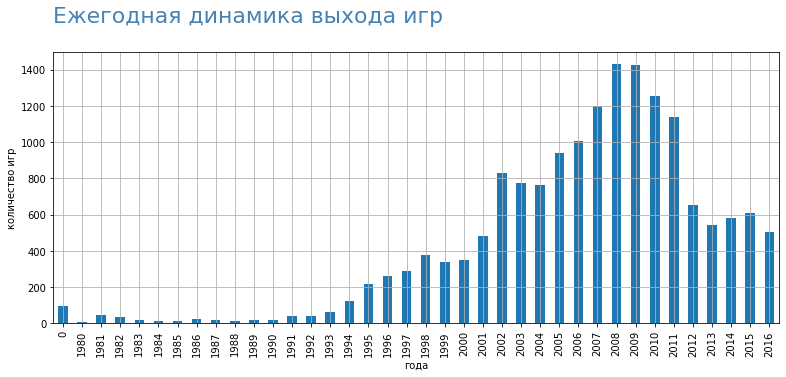

In [61]:
ax = data['year_of_release'].value_counts().sort_index(ascending=True).plot(
    kind='bar',
    grid=True,
    figsize=(13,5)
)
ax.set_title('Ежегодная динамика выхода игр' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
ax.set_xlabel("года")
ax.set_ylabel("количество игр");

In [62]:
data['year_of_release'].value_counts().describe()

count      38.000000
mean      435.263158
std       449.207150
min         9.000000
25%        37.250000
50%       313.500000
75%       734.500000
max      1428.000000
Name: year_of_release, dtype: float64

Данные имеют вид графика нормлаьно распределения, со здвигом вправа и выбросом в нуле (в виду особенностей обработки данных).

Пик игровой индустрии - 2008-2009 годы

В среднем в год выпускается 447 игр. Пик 1429 - в 2008 году, минимум 9 игр - 1980г.

Из данных уберем нулевой год

In [63]:
data = data.query('year_of_release != 0')
data['year_of_release'].value_counts().describe()

count      37.000000
mean      444.486486
std       451.740869
min         9.000000
25%        36.000000
50%       338.000000
75%       762.000000
max      1428.000000
Name: year_of_release, dtype: float64

### Посмотрите, как менялись продажи по платформам
Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [64]:
d_platform_pivot = data.pivot_table(index=['platform','year_of_release'], values=['name','world_sales'], \
                                             aggfunc=['count','sum'])
d_platform_pivot.columns = d_platform_pivot.columns.droplevel(1)
d_platform_pivot.columns = ['name', 'del_col', 'world_sales']
d_platform_pivot = d_platform_pivot.drop('del_col', axis=1)
d_platform_pivot = d_platform_pivot.sort_values(by='year_of_release')

Подготовим данные для **графика продаж игр на разных платформах**

Преобразуем сводную таблицу в датафрейм

In [65]:
d_platform_pivot = d_platform_pivot.reset_index()

In [66]:
d_platform_pivot

,platform,year_of_release,name,world_sales
0,2600,1980,9,11.38
1,2600,1981,46,35.68
2,2600,1982,36,28.88
3,2600,1983,11,5.84
4,NES,1983,6,10.96
...,...,...,...,...
233,PS4,2016,164,69.25
234,PS3,2016,38,3.60
235,3DS,2016,46,15.14
236,X360,2016,13,1.52


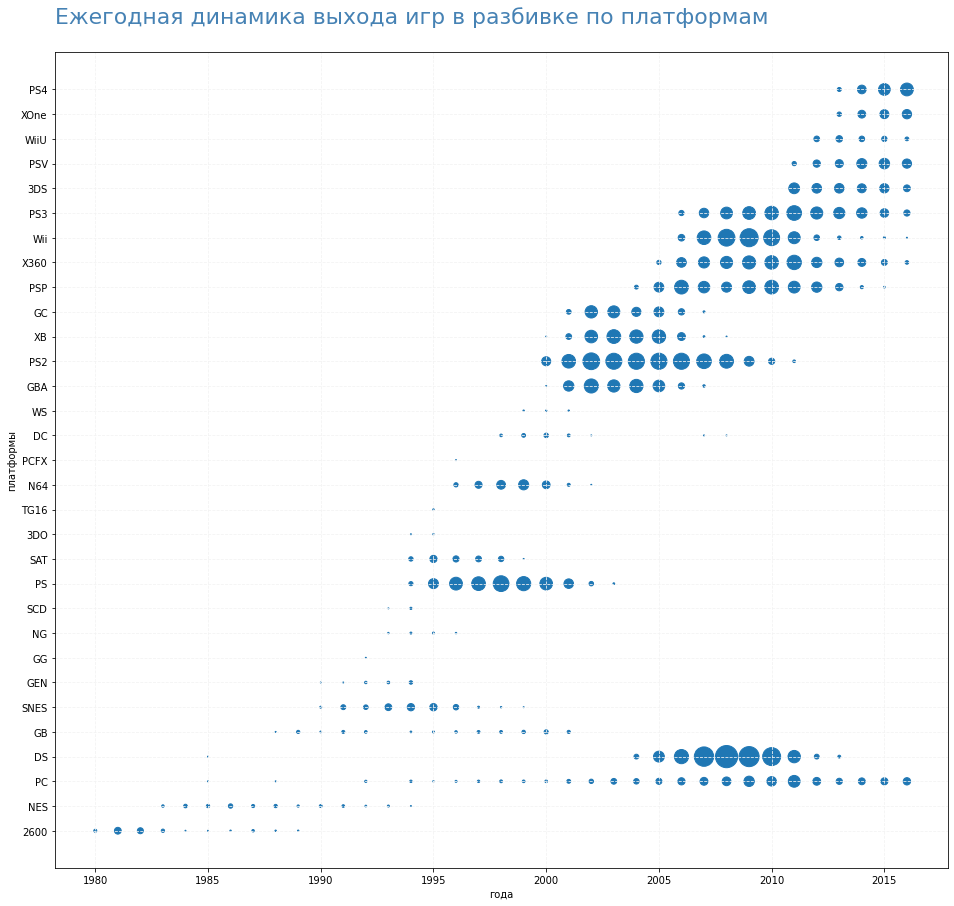

In [67]:
plt.figure(figsize=(16, 15))
plt.grid(color='#f3f3f3', linestyle='--')

plt.scatter('year_of_release', 'platform', s='name', data=d_platform_pivot);

plt.title('Ежегодная динамика выхода игр в разбивке по платформам' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
plt.xlabel("года")
plt.ylabel("платформы");

Уберем из данных:  
 - DS — выброс 1985 года
 - PC — слишком долго на рынке и не игровая приставка
 - платформы однодневки (GG, TG16, PCFX)
 - новые платформы (PS4, XOne, WiiU, PSV, 3DS, PS3)

In [68]:
d_platform_pivot = d_platform_pivot.query("platform not in ('PC', 'GG', 'TG16', 'PCFX',  \
                                            'PS4', 'XOne', 'WiiU', 'PSV', '3DS', 'PS3')")
d_platform_pivot = d_platform_pivot[(d_platform_pivot["platform"] != 'DS') & (d_platform_pivot['year_of_release'] != 1985)]

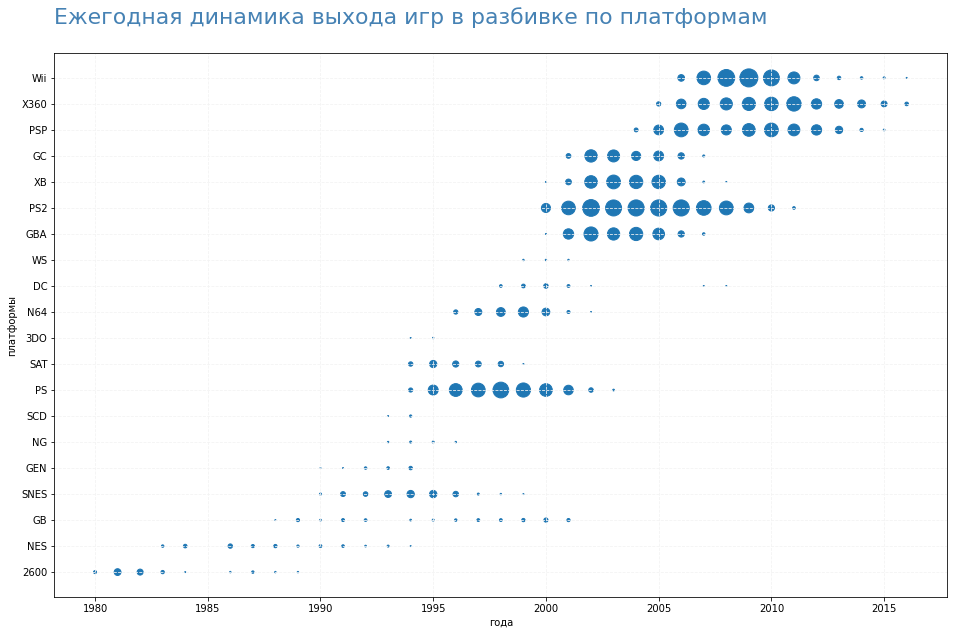

In [69]:
plt.figure(figsize=(16, 10))
plt.grid(color='#f3f3f3', linestyle='--')
# ax.set_axisbelow(True)

plt.scatter('year_of_release', 'platform', s='name', data=d_platform_pivot);

plt.title('Ежегодная динамика выхода игр в разбивке по платформам' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
plt.xlabel("года")
plt.ylabel("платформы");

Найдем примерный период популярности консолей

In [70]:
age_popularity_platform = d_platform_pivot[['year_of_release', 'platform']].drop_duplicates()
age_popularity_platform = age_popularity_platform. \
                                            pivot_table(index='platform', values='year_of_release', aggfunc='count'). \
                                            sort_values(by='year_of_release',ascending=False)
age_popularity_platform

,year_of_release
platform,
GB,13
X360,12
PSP,12
PS2,12
NES,11
Wii,11
PS,10
SNES,10
2600,9


In [71]:
age_popularity_platform.describe()

,year_of_release
count,20.000000
mean,8.000000
std,3.479262
min,2.000000
25%,5.750000
50%,8.500000
75%,11.000000
max,13.000000


Избавившись от консолей, которые только вышли, или которые были на рынке менее 2-х лет и ПК мы получили следующее:

Средний срок службы консоли - 8 лет. 

Начиная с 1990 года количество и частота выхода консолей увеличивается, можно увидеть, что консоли выходят примерно раз в 3 года в один и тот же год от разных производителей

С 2000 г объем выхода игр на платформы сильно вырос, до этого, чтолько PS показывала высокие результаты. Можно сказать, что с PS начался расцвет и вхождение в массы консолей по всему миру

Платформы с наибольшим суммарными продажами:

In [72]:
top_platform_pivot = d_platform_pivot.pivot_table(index='platform', values='world_sales', aggfunc='sum'). \
                          sort_values(by='world_sales',ascending=False)
top_platform_pivot.head(10)

,world_sales
platform,
PS2,1233.56
X360,961.30
Wii,891.18
PS,727.58
GBA,312.88
PSP,289.54
GB,254.43
XB,251.57
N64,218.01


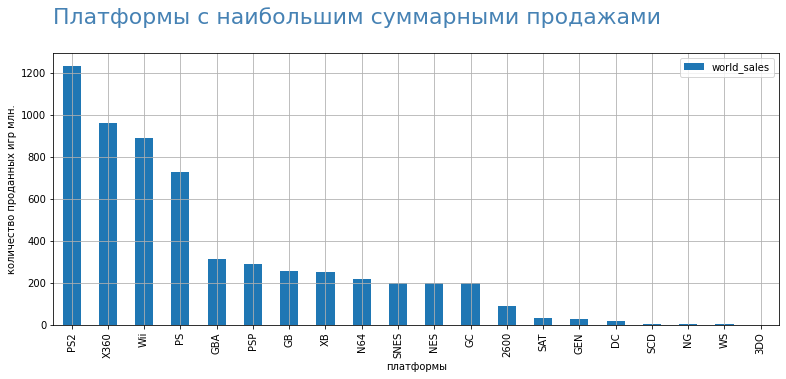

In [73]:
top_platform_pivot.plot(
    kind='bar',
    grid=True,
    figsize=(13,5)
);

plt.title('Платформы с наибольшим суммарными продажами' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
plt.xlabel("платформы")
plt.ylabel("количество проданных игр млн.");

Видны три группы консолей:
- PS2
- X360, PS3, Wii, DS, PS
- GBA, PS4, PSP, PC и пр.

Посмотрим ретроспективный график для ТОП-10 платформ

In [74]:
d_platform_pivot3 = d_platform_pivot[d_platform_pivot['platform'].isin(top_platform_pivot.head(10).index)]

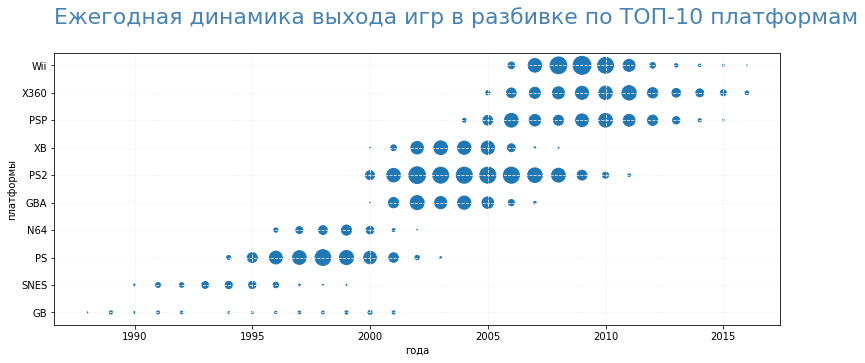

In [75]:
plt.figure(figsize=(13, 5))
plt.grid(color='#f3f3f3', linestyle='--')
# ax.set_axisbelow(True)

plt.scatter('year_of_release', 'platform', s='name', data=d_platform_pivot3);

plt.title('Ежегодная динамика выхода игр в разбивке по ТОП-10 платформам' + "\n", loc="left", fontsize = 22, color = 'SteelBlue');
plt.xlabel("года")
plt.ylabel("платформы");

ТОП-10 консолей представлены 3-мя компаниями: Sony, Nintendo и Microsoft  
Построим график суммарных продаж этих 3-х когорт за все года:

In [76]:
Nintendo = ['Wii', 'N64', 'GBA', 'SNES', 'NES', 'DS']
Sony = ['PS2', 'PS3', 'PS', 'PS4', 'PSP']
Microsoft = ['X360']

In [77]:
Nin_cir = dict((Nintendo[i], d_platform_pivot3[d_platform_pivot3['platform'] == Nintendo[i]] \
                                            ['name'].sum()) for i in range(len(Nintendo)))
Sony_cir = dict((Sony[i], d_platform_pivot3[d_platform_pivot3['platform'] == Sony[i]] \
                                            ['name'].sum()) for i in range(len(Sony)))
MS_cir = dict((Microsoft[i], d_platform_pivot3[d_platform_pivot3['platform'] == Microsoft[i]] \
                                            ['name'].sum()) for i in range(len(Microsoft)))

In [78]:
Nin_cir = dict((Nintendo[i], d_platform_pivot[d_platform_pivot['platform'] == Nintendo[i]] \
                                            ['name'].sum()) for i in range(len(Nintendo)))
Sony_cir = dict((Sony[i], d_platform_pivot[d_platform_pivot['platform'] == Sony[i]] \
                                            ['name'].sum()) for i in range(len(Sony)))
MS_cir = dict((Microsoft[i], d_platform_pivot[d_platform_pivot['platform'] == Microsoft[i]] \
                                            ['name'].sum()) for i in range(len(Microsoft)))

In [79]:
platform_sony = [{'id': k, 'datum': v} for k, v in Sony_cir.items()]
platform_nintendo = [{'id': k, 'datum': v} for k, v in Nin_cir.items()]
platform_microsoft = [{'id': k, 'datum': v} for k, v in MS_cir.items()]

platform_circ = [{
    'id': 'Platforms',
    'datum': sum(Sony_cir.values()) + sum(Nin_cir.values()) + sum(MS_cir.values()),
    'children': [
        {'id': 'Sony', 'datum': sum(Sony_cir.values()), 'children': platform_sony},
        {'id': 'Nintendo', 'datum': sum(Nin_cir.values()), 'children': platform_nintendo},
        {'id': 'Microsoft', 'datum': sum(MS_cir.values()), 'children': platform_microsoft}
    ]
}]

In [80]:
# Compute circle positions thanks to the circlify() function
circles = circlify.circlify(
    platform_circ, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

min to max ratio is too low at 0.000000 and it could cause algorithm stability issues. Try to remove insignificant data
min to max ratio is too low at 0.000000 and it could cause algorithm stability issues. Try to remove insignificant data


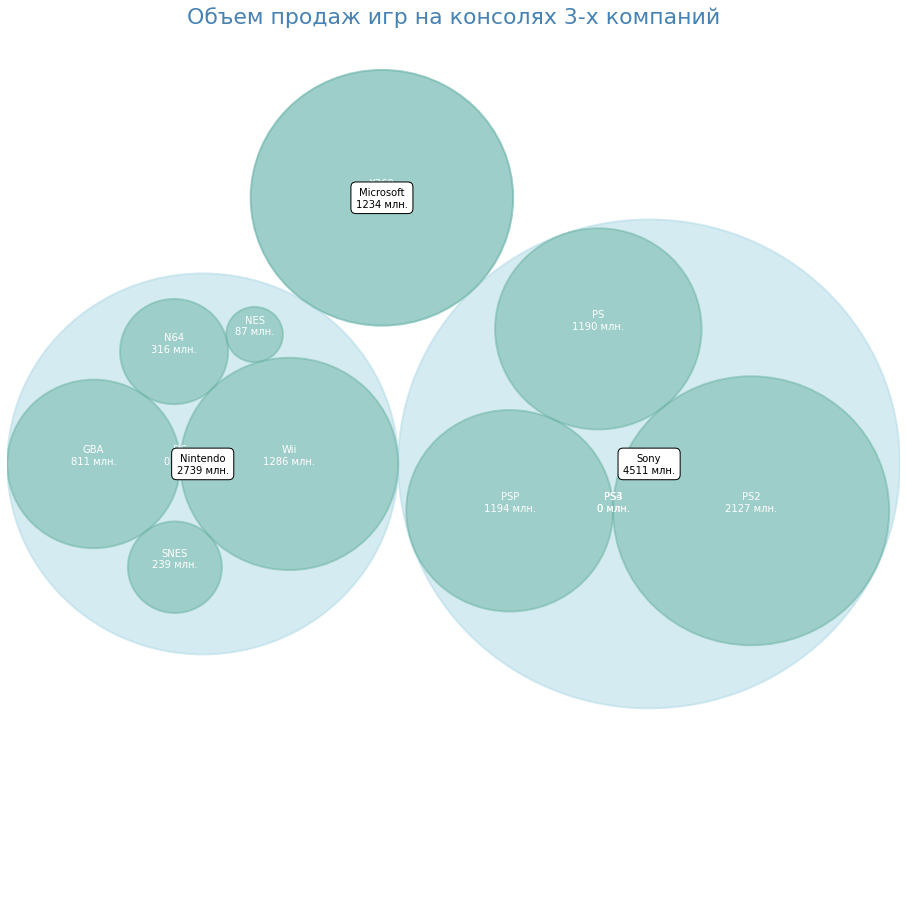

In [81]:
# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(16,16))

# Title
ax.set_title('Объем продаж игр на консолях 3-х компаний', fontsize = 22, color = 'SteelBlue')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Print circle the highest level (continents):
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="lightblue"))

# Print circle and labels for the highest level:
for circle in circles:
    if circle.level != 3:
      continue
    x, y, r = circle
    label = "\n".join([circle.ex["id"], " ".join([str(circle.ex["datum"]), 'млн.'])])
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#69b3a2"))
    plt.annotate(label, (x,y ), ha='center', color="white")

# Print labels for the continents
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = "\n".join([circle.ex["id"], " ".join([str(circle.ex["datum"]), 'млн.'])])
    plt.annotate(label, (x,y ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', \
                                             boxstyle='round', pad=.5))

Примем, что актуальный период для нашего анализа начиная с 2014г, т.к. данные за 2016 не полны, мы не можем взять только 2016 год, но и игнорировать его не стоит, т.к. данных в 2016 немного меньше. Данных за 2015 год не хватит, мы можем упустить фактор сезонность
Платформы с наибольшим суммарными продажами за актуальный период:

In [82]:
top_platform_actual_time = data.query('year_of_release >= 2014').pivot_table(index='platform', values='world_sales', \
                                             aggfunc='sum').sort_values(by='world_sales',ascending=False)
top_platform_actual_time

,world_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40
Wii,5.07


Создадим новый массив данных с датой релиза игр от 2014г и старше

In [83]:
data_2014 = data.query('year_of_release >= 2014')
data_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16539
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            1689 non-null   int64  
 1   name             1689 non-null   object 
 2   platform         1689 non-null   object 
 3   year_of_release  1689 non-null   int64  
 4   genre            1689 non-null   object 
 5   na_sales         1689 non-null   float64
 6   eu_sales         1689 non-null   float64
 7   jp_sales         1689 non-null   float64
 8   other_sales      1689 non-null   float64
 9   critic_score     1689 non-null   float64
 10  user_score       1689 non-null   float64
 11  rating           1689 non-null   object 
 12  world_sales      1689 non-null   float64
dtypes: float64(7), int64(2), object(4)
memory usage: 184.7+ KB


### График «ящик с усами»
Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

Выбираем дату с 2014 года по результату анализа графика продаж игр на разных платформах

In [84]:
data_2014.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
31,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0.0,0.0,tbd,14.63
42,42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,0.0,0.0,tbd,11.68
77,77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,0.0,0.0,tbd,7.98


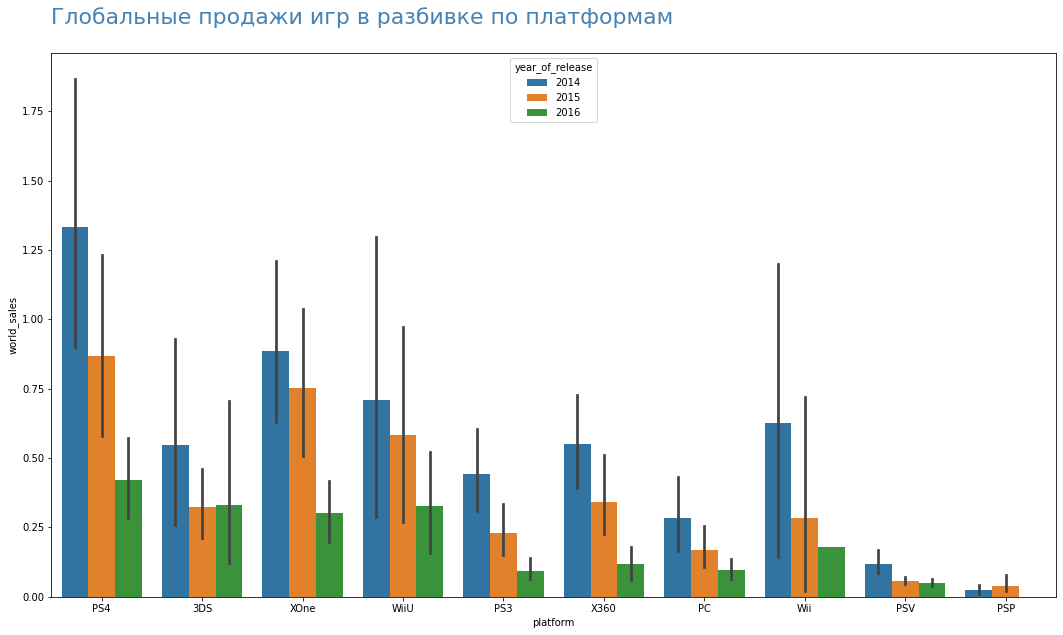

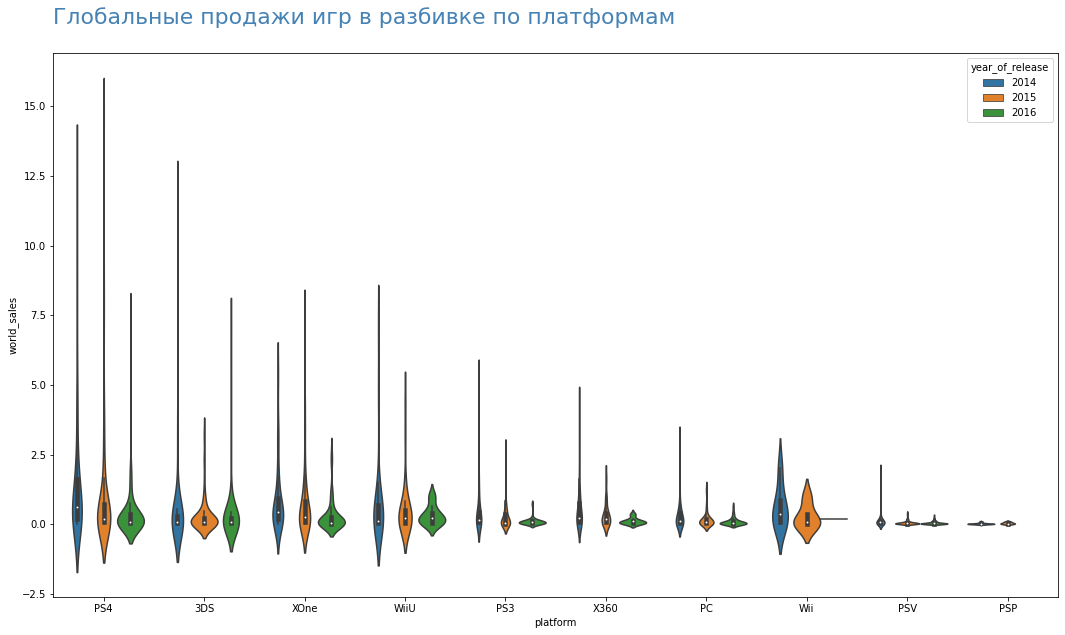

In [85]:
# plot barplot chart
plt.figure(figsize=(18, 10))
sns.barplot(x='platform', y='world_sales', hue='year_of_release', data=data_2014)

# add title
plt.title("Глобальные продажи игр в разбивке по платформам" + "\n", loc="left", fontsize = 22, color = 'SteelBlue')

# show the graph
plt.show()

# plot violin chart
plt.figure(figsize=(18, 10))
sns.violinplot(x='platform', y='world_sales', hue='year_of_release', data=data_2014)

# add title
plt.title("Глобальные продажи игр в разбивке по платформам" + "\n", loc="left", fontsize = 22, color = 'SteelBlue')

# show the graph
plt.show()

ТОП-3 перспективные платформы: 
 - PS4
 - XOne
 - WiiU  

Ожидаемо новые консоли перспективнее. Так же можно добавить в список 3DS, консоли предыдущего поколения и ПК


### Влияние на продажи игр на PS4 отзывов пользователей и критиков.
Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Будем смотреть данные на данных платформы PS4
Уберем из данных нулевые оценки пользователей и критиков, на остновании полученных построим диаграммы рассеявания мировые продажи-оценка пользователей, мировые продажи-оценка критиков, и посмотрим корреляцию этих показателей

In [86]:
ps4_data = data_2014.query("platform == 'PS4' and user_score != 'tbd'")[['world_sales','user_score','critic_score']]
ps4_data['user_score'] = ps4_data['user_score'].astype('float')
# ps4_data = ps4_data.query("user_score > 0 and critic_score > 0")
ps4_data.query("user_score > 0")

,world_sales,user_score,critic_score
42,12.62,8.3,97.0
77,8.58,4.3,82.0
92,7.66,5.7,83.0
94,7.60,5.0,85.0
105,7.17,6.5,87.0
...,...,...,...
16312,0.01,2.3,42.0
16325,0.01,6.8,70.0
16326,0.01,7.5,69.0
16351,0.01,7.9,61.0


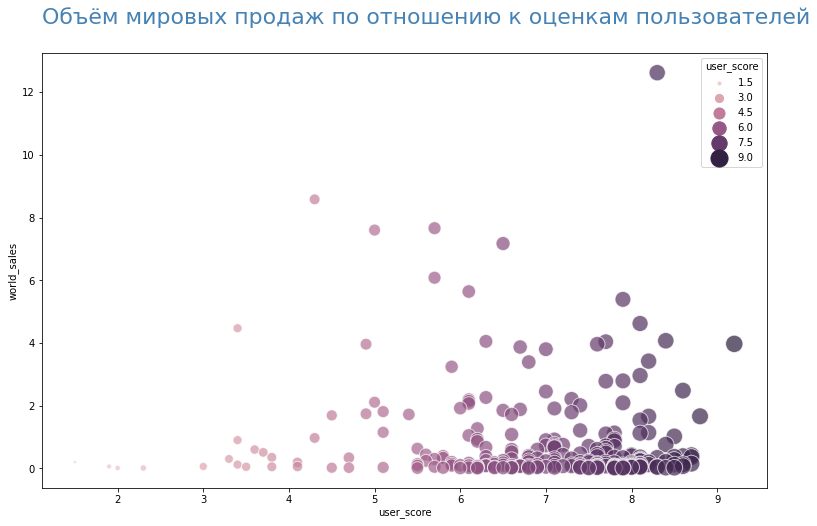

In [87]:
plt.figure(figsize=(13, 8))
plt.title("Объём мировых продаж по отношению к оценкам пользователей" + "\n", loc="left", fontsize = 22, color = 'SteelBlue')
sns.scatterplot(x='user_score', y='world_sales', hue = 'user_score', size = 'user_score', sizes = (10,300), \
                                             alpha=0.7, data=ps4_data.query("user_score > 0"));

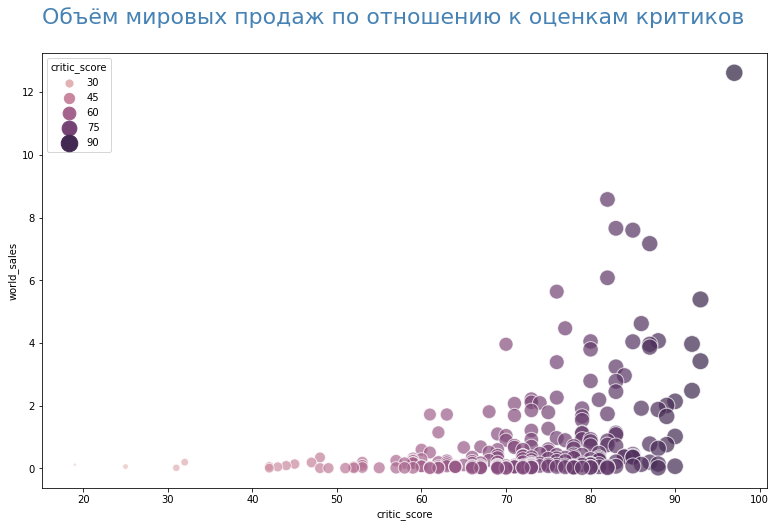

In [88]:
plt.figure(figsize=(13, 8))
plt.title("Объём мировых продаж по отношению к оценкам критиков" + "\n", loc="left", fontsize = 22, color = 'SteelBlue')
sns.scatterplot(x='critic_score', y='world_sales', hue = 'critic_score', size = 'critic_score', sizes = (10,300), \
                                             alpha=0.7, data=ps4_data.query("critic_score > 0"));

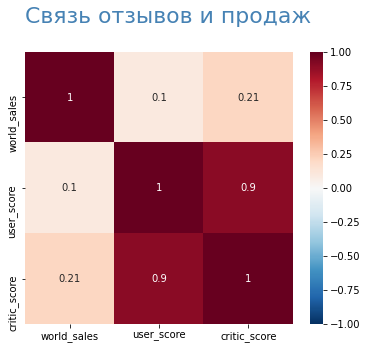

In [89]:
plt.figure(figsize=(6, 5))
plt.title("Связь отзывов и продаж" + "\n", loc="left", fontsize = 22, color = 'SteelBlue')
sns.heatmap(ps4_data.corr(), cmap='RdBu_r', annot=True, vmin=-1, vmax=1);

Связь между оценки пользователей и мировыми продажами - **слабая**  
Связь между оценками критиков и мировыми продажами - **слабая**  
Корреляция между оценками пользователей и критиков - **высокая**

Как мы увидели, объемы продаж не всегда коррелируют с оценками пользователей

### Соотнесите выводы с продажами игр на других платформах.

Посмотрим данные для оставшихся двух перспективных платформ **XOne** и **WiiU**

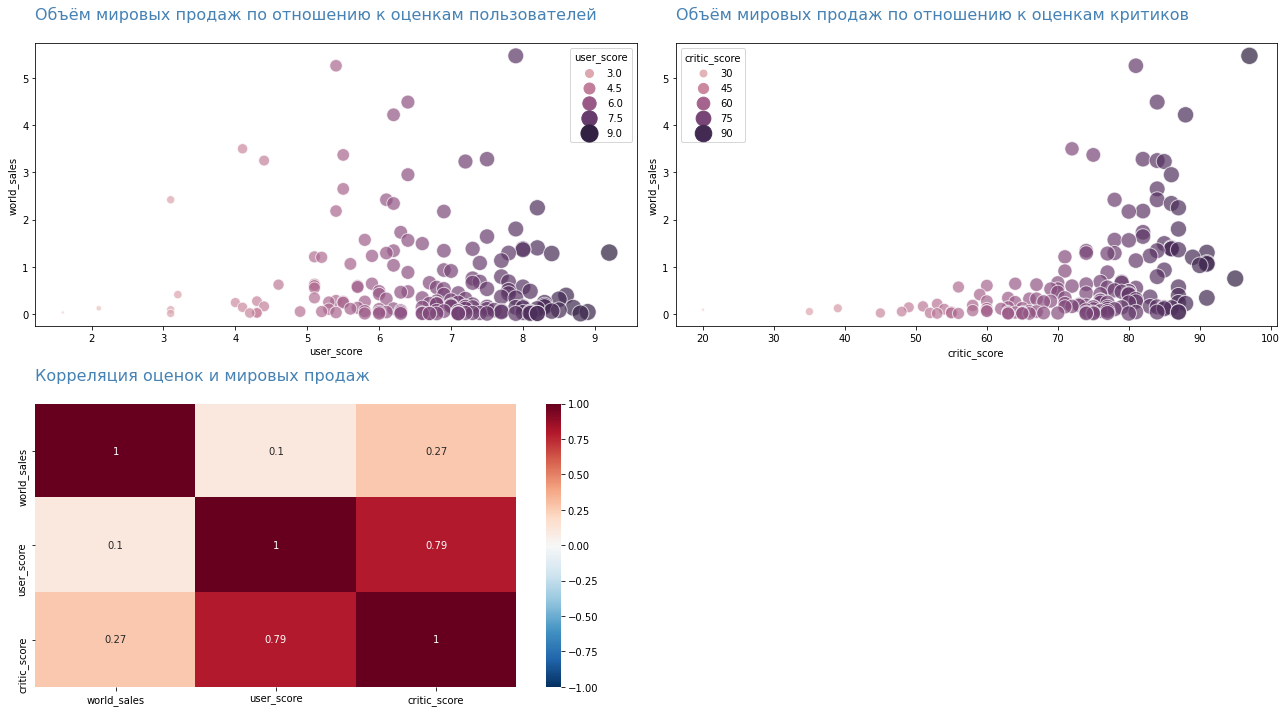

In [90]:
xone_data = data_2014.query("platform == 'XOne' and user_score != 'tbd'")[['world_sales','user_score','critic_score']]
xone_data['user_score'] = xone_data['user_score'].astype('float')


fig, axes = plt.subplots(2, 2, squeeze=False, figsize=(18, 10))

sns.scatterplot(data=xone_data.query("user_score > 0"), x='user_score', y='world_sales', \
                                     hue = 'user_score', size = 'user_score', sizes = (10,300), alpha=0.7, ax=axes[0,0]);
sns.scatterplot(data=xone_data.query("critic_score > 0"), x='critic_score', y='world_sales', \
                                     hue = 'critic_score', size = 'critic_score', sizes = (10,300), alpha=0.7, ax=axes[0,1])
sns.heatmap(xone_data.corr(), cmap='RdBu_r', annot=True, vmin=-1, vmax=1, ax=axes[1,0]);

axes[0,0].set_title("Объём мировых продаж по отношению к оценкам пользователей" + "\n", \
                    loc="left", fontsize = 16, color = 'SteelBlue')
axes[0,1].set_title("Объём мировых продаж по отношению к оценкам критиков" + "\n", \
                    loc="left", fontsize = 16, color = 'SteelBlue')
axes[1,0].set_title("Корреляция оценок и мировых продаж" + "\n", loc="left", fontsize = 16, color = 'SteelBlue')

fig.delaxes(axes[1,1])
fig.tight_layout()
plt.show()

Связь между оценки пользователей и мировыми продажами - **слабая**
Связь между оценками критиков и мировыми продажами - **слабая**  
Корреляция между оценками пользователей и критиков - **высокая**

Связи XOne схожи со связями PS4

Влияние на продажи игр на **WiiU** отзывов пользователей и критиков.

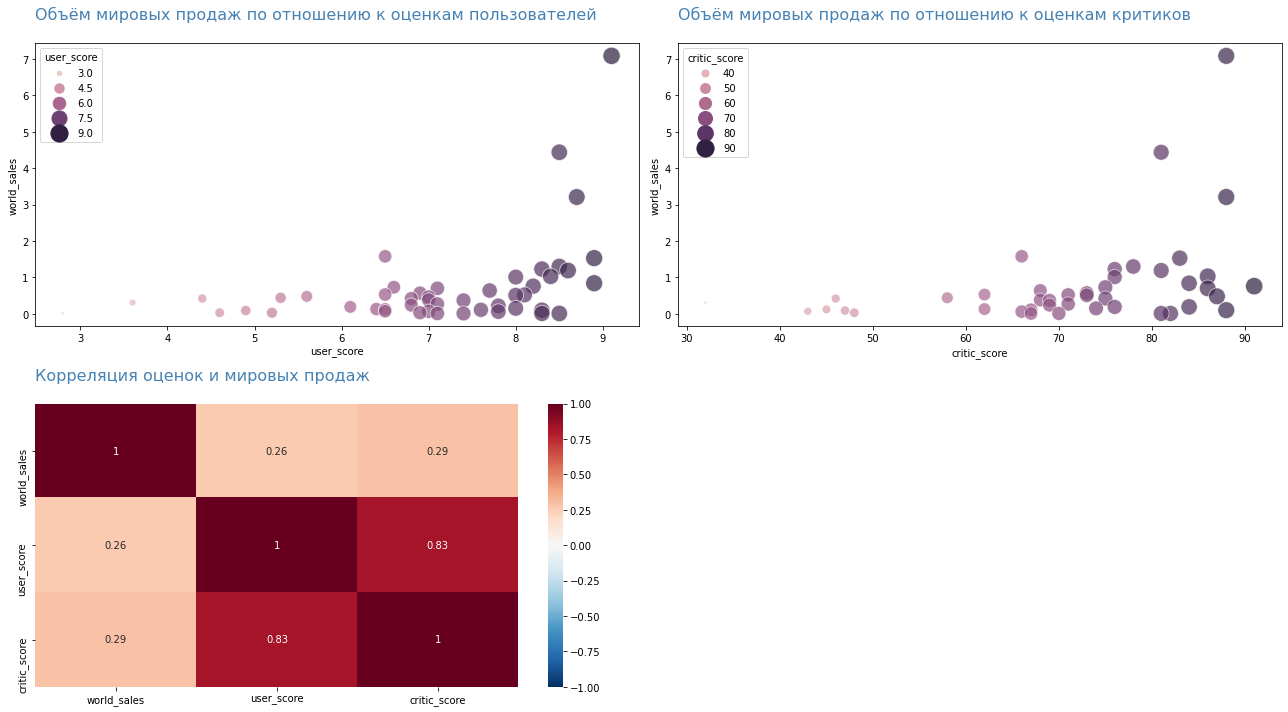

In [91]:
n_wiiu_data = data_2014.query("platform == 'WiiU' and user_score != 'tbd'")[['world_sales','user_score','critic_score']]
n_wiiu_data['user_score'] = n_wiiu_data['user_score'].astype('float')


fig, axes = plt.subplots(2, 2, squeeze=False, figsize=(18, 10))

sns.scatterplot(data=n_wiiu_data.query("user_score > 0"), x='user_score', y='world_sales',  \
                                       hue = 'user_score', size = 'user_score', sizes = (10,300), alpha=0.7, ax=axes[0,0]);
sns.scatterplot(data=n_wiiu_data.query("critic_score > 0"), x='critic_score', y='world_sales',  \
                                       hue = 'critic_score', size = 'critic_score', sizes = (10,300), alpha=0.7, ax=axes[0,1])
sns.heatmap(n_wiiu_data.corr(), cmap='RdBu_r', annot=True, vmin=-1, vmax=1, ax=axes[1,0]);

axes[0,0].set_title("Объём мировых продаж по отношению к оценкам пользователей" + "\n", \
                    loc="left", fontsize = 16, color = 'SteelBlue')
axes[0,1].set_title("Объём мировых продаж по отношению к оценкам критиков" + "\n", \
                    loc="left", fontsize = 16, color = 'SteelBlue')
axes[1,0].set_title("Корреляция оценок и мировых продаж" + "\n", loc="left", fontsize = 16, color = 'SteelBlue')

fig.delaxes(axes[1,1])
fig.tight_layout()
plt.show()

Связь между оценки пользователей и мировыми продажами - **слабая**
Связь между оценками критиков и мировыми продажами - **слабая** 
Корреляция между оценками пользователей и критиков - **высокая**

WiiU имеет бОльшую связь отзывов и продаж по сравнению с **PS4** и **XOne**

Значения корреляции оценок пользователей и критиков  хоть и находятся в одной категории "высокая связь" но имеют разброс от 0.79 до 0.9

### Распределение игр по жанрам
Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [92]:
genre_data = data_2014[['genre','year_of_release','world_sales']]

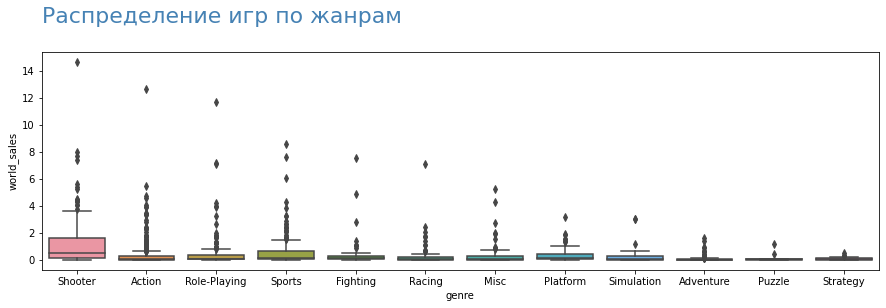

In [132]:
# plot violin chart
plt.figure(figsize=(15, 4))
sns.boxplot(x='genre', y='world_sales', data=data_2014)
# add title
plt.title("Распределение игр по жанрам" + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

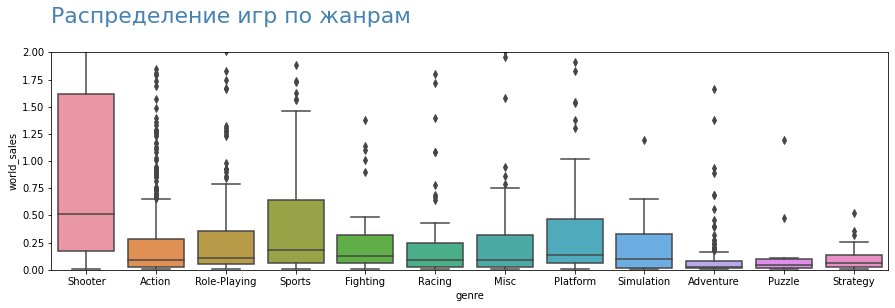

In [133]:
# plot violin chart
plt.figure(figsize=(15, 4))
sns.boxplot(x='genre', y='world_sales', data=data_2014)
plt.ylim(0,2)
# add title
plt.title("Распределение игр по жанрам" + "\n", loc="left", fontsize = 22, color = 'SteelBlue');

Первый график показывает самые удачные релизы - игры приносяцие максимальную прибыль - это хороший способ определять наиболее привлекательные для пользователей игры.  
Второй график показывает количество продаваемых игр на платформах/жанрах - какая из них более стабильна в продажах

In [96]:
data_2014.query('genre == "Shooter"')[['name','platform','world_sales']].sort_values(by='world_sales', ascending=False).head(10)

,name,platform,world_sales
31,Call of Duty: Black Ops 3,PS4,14.63
87,Star Wars Battlefront (2015),PS4,7.98
92,Call of Duty: Advanced Warfare,PS4,7.66
99,Call of Duty: Black Ops 3,XOne,7.39
154,Destiny,PS4,5.64
171,Uncharted 4: A Thief's End,PS4,5.39
179,Call of Duty: Advanced Warfare,XOne,5.26
241,Halo 5: Guardians,XOne,4.49
244,Call of Duty: Infinite Warfare,PS4,4.47
246,Splatoon,WiiU,4.44


In [97]:
data_2014.query('genre == "Shooter"')[['name','platform','world_sales']].describe()

,world_sales
count,128.000000
mean,1.335469
std,2.050567
min,0.010000
25%,0.172500
50%,0.515000
75%,1.617500
max,14.630000


Пик продаж был у **Shooter** - релиз Call of Duty: Black Ops 3  
Далее идут **Action**, **Role-Playing**, **Sport**, **Fighting**   

Хуже всего обстоят дела у жанров **Adventure**, **Puzzle** и **Strategy** 

### Вывод:
Мы выяснили, что спад в глобальных продахаж начался с 2008 года

Срок жизни платформ 8 лет. Примерно раз в 5 лет выходит новая консоль. Долгожитель - ПК - 27 лет  
Лидеры по объемам продаж за актуальный период - PS4 (188.15млн). Следом идут: XOne, 3DS, WiiU, PS3

Среди компаний-производителей консолей по суммарным продажам: Sony ~ 4'511млн; Nintendo ~ 2'739млн; Microsoft ~1'234млн

За актуальный период (2014-2016гг):
 - Обнаружили отсутствие корреляции отзывов пользователей на объемы продаж на PS4 и XOne. Слабая связь оценки критиков и продаж на этих же платформах.
 - Умеренная зависимость отзывов пользователей и критиков на объемы продаж видна WiiU
 - Популярные жанры: **Shooter**, **Action**, **Role-Playing**, **Sport**, **Fighting** 
 - В конце списка: **Adventure**, **Strategy** и **Puzzle**

## Шаг. Составьте портрет пользователя каждого региона
Определите для пользователя каждого региона (NA, EU, JP):

### Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [98]:
na_platforn = data_2014.query('na_sales > 0').pivot_table(index='platform', values='na_sales', aggfunc='sum')
eu_platforn = data_2014.query('eu_sales > 0').pivot_table(index='platform', values='eu_sales', aggfunc='sum')
jp_platforn = data_2014.query('jp_sales > 0').pivot_table(index='platform', values='jp_sales', aggfunc='sum')

na_platforn = na_platforn.reset_index()
eu_platforn = eu_platforn.reset_index()
jp_platforn = jp_platforn.reset_index()

na_platforn.columns = ['main', 'second']
eu_platforn.columns = ['main', 'second']
jp_platforn.columns = ['main', 'second']

Функция для создания ТОП-5 групп и other, как все остальные позици.. Функция подойдёт и для жанров и для платформ

In [99]:
def funk_merge (df):
    # группировка по значению в столбце 'store' и вычисление суммы значений столбца 'quarter' для каждой группы
    grouped_df = df.groupby('main')['second'].sum()

    # сортировка групп в порядке убывания суммы значений
    grouped_df = grouped_df.sort_values(ascending=False)

    # выбор первых 5 групп и объединение остальных в группу 'other'
    top_5_groups = grouped_df.head(5).index.tolist()
    other_group = 'other'
    other_sum = grouped_df.tail(len(grouped_df) - 5).sum()

    # добавление группы 'other' в список групп
    groups = top_5_groups + [other_group]

    # вычисление суммы значений столбца 'quarter' для каждой группы
    sums = []
    for group in groups:
        if group == other_group:
            sums.append(other_sum)
        else:
            sums.append(grouped_df.loc[group])

    # создание нового DataFrame
    new_df = pd.DataFrame({'main': groups, 'second': sums})
    return (new_df)


In [100]:
na_platforn = funk_merge(na_platforn)
eu_platforn = funk_merge(eu_platforn)
jp_platforn = funk_merge(jp_platforn)

In [157]:
na_platforn

,main,second
0,PS4,98.61
1,XOne,81.27
2,X360,28.30
3,3DS,22.64
4,PS3,22.05
5,other,31.19


In [161]:
axs[0].pie(na_platforn.na_sales, labels=na_platforn.index, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3}, autopct='%1.1f%%')
axs[0].set_title('Популярность жанров в Северной Америке')

# Create a pieplot
axs[1].pie(eu_platforn.eu_sales, labels=eu_platforn.index, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3 }, autopct='%1.1f%%')
axs[1].set_title('Популярность жанров в Европе')

# Create a pieplot
axs[2].pie(jp_platforn.jp_sales, labels=jp_platforn.index, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3 }, autopct='%1.1f%%')
axs[2].set_title('Популярность жанров в Японии')


fig, axes = plt.subplots(3, 1, figsize=(13,10))

na_platforn.sort_values(by='na_sales').plot.barh(legend=False, title='ТОП-5 жанров Северной Америки', ax = axes[0])
axes[0].set_xlabel("продажи в регионе, млн")
axes[0].set_ylabel("жанры");

eu_platforn.sort_values(by='eu_sales').plot.barh(legend=False, title='ТОП-5 жанров Европы', ax = axes[1])
axes[1].set_xlabel("продажи в регионе, млн")
axes[1].set_ylabel("жанры");

jp_platforn.sort_values(by='jp_sales').plot.barh(legend=False, title='ТОП-5 жанров Японии', ax = axes[2])
axes[2].set_xlabel("продажи в регионе, млн")
axes[2].set_ylabel("жанры");

plt.tight_layout()

AttributeError: 'DataFrame' object has no attribute 'na_sales'

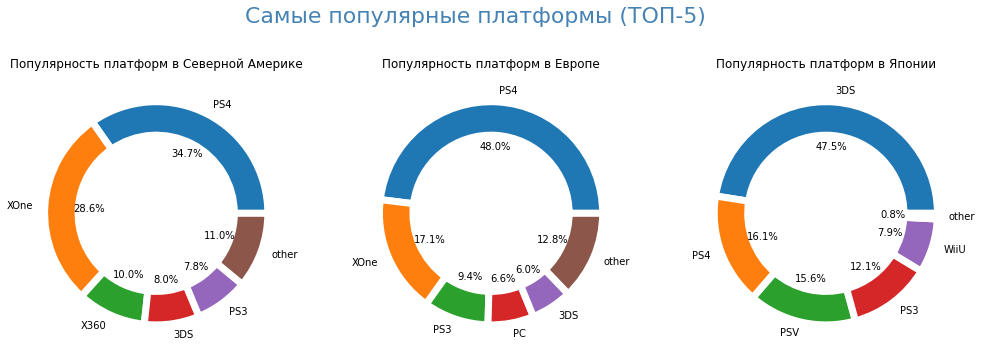

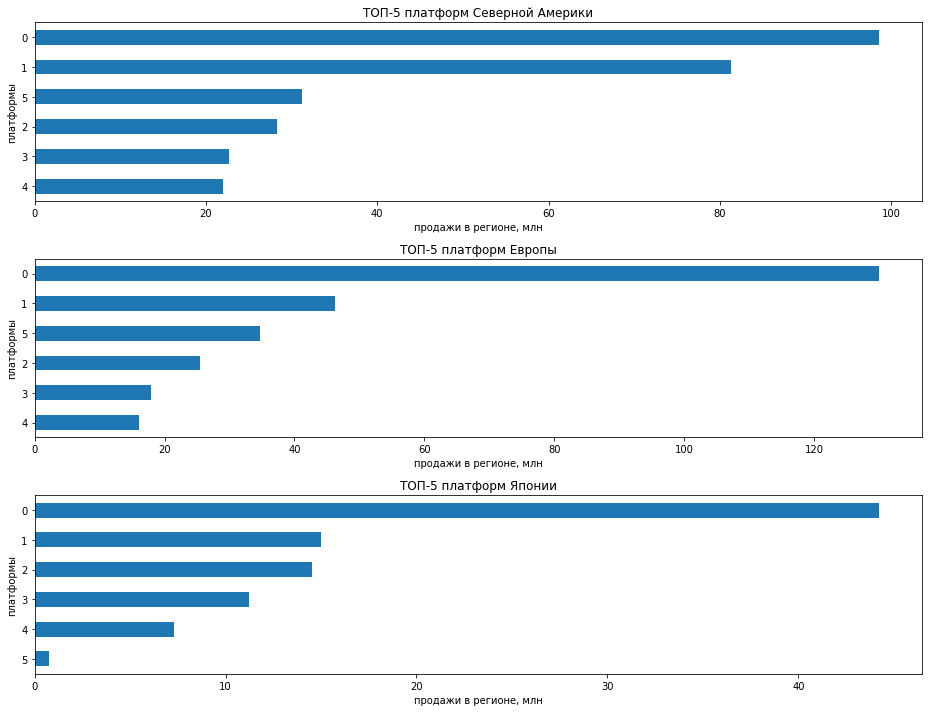

In [164]:
fig, axs = plt.subplots(1, 3, figsize=(17, 6))

fig.suptitle('Самые популярные платформы (ТОП-5)', fontsize = 22, color = 'SteelBlue');

# Create a pieplot
axs[0].pie(na_platforn.second, labels=na_platforn.main, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3}, autopct='%1.1f%%')
axs[0].set_title('Популярность платформ в Северной Америке')

# Create a pieplot
axs[1].pie(eu_platforn.second, labels=eu_platforn.main, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3 }, autopct='%1.1f%%')
axs[1].set_title('Популярность платформ в Европе')

# Create a pieplot
axs[2].pie(jp_platforn.second, labels=jp_platforn.main, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3 }, autopct='%1.1f%%')
axs[2].set_title('Популярность платформ в Японии')


fig, axes = plt.subplots(3, 1, figsize=(13,10))

na_platforn.sort_values(by='second').plot.barh(legend=False, title='ТОП-5 платформ Северной Америки', ax = axes[0])
axes[0].set_xlabel("продажи в регионе, млн")
axes[0].set_ylabel("платформы");

eu_platforn.sort_values(by='second').plot.barh(legend=False, title='ТОП-5 платформ Европы', ax = axes[1])
axes[1].set_xlabel("продажи в регионе, млн")
axes[1].set_ylabel("платформы");

jp_platforn.sort_values(by='second').plot.barh(legend=False, title='ТОП-5 платформ Японии', ax = axes[2])
axes[2].set_xlabel("продажи в регионе, млн")
axes[2].set_ylabel("платформы");

plt.tight_layout()

- Самые популярные платформы (топ-5):
 - В регионе NA лидирует PS4, с долей продаж 42.1%, вторая платформа XOne - 33.1%, на 5 месте: X360 - 5.3%  
 - В регионе EU лидирует PS4, с долей продаж 56.5%, вторая платформа XOne - 19%, на 5 месте: PS3 - 4.9%  
 - В регионе JP лидирует 3DS, с долей продаж 44.1%, вторая платформа PS4 - 22,6%, на 5 месте: WiiU - 7,7%  

### Самые популярные жанры (топ-5). Поясните разницу.

In [102]:
na_genre = data_2014.query('na_sales > 0').pivot_table(index='genre', values='na_sales', aggfunc='sum'). \
                                            sort_values(by='na_sales',ascending=False).head(5)
eu_genre = data_2014.query('eu_sales > 0').pivot_table(index='genre', values='eu_sales', aggfunc='sum'). \
                                            sort_values(by='eu_sales',ascending=False).head(5)
jp_genre = data_2014.query('jp_sales > 0').pivot_table(index='genre', values='jp_sales', aggfunc='sum'). \
                                            sort_values(by='jp_sales',ascending=False).head(5)

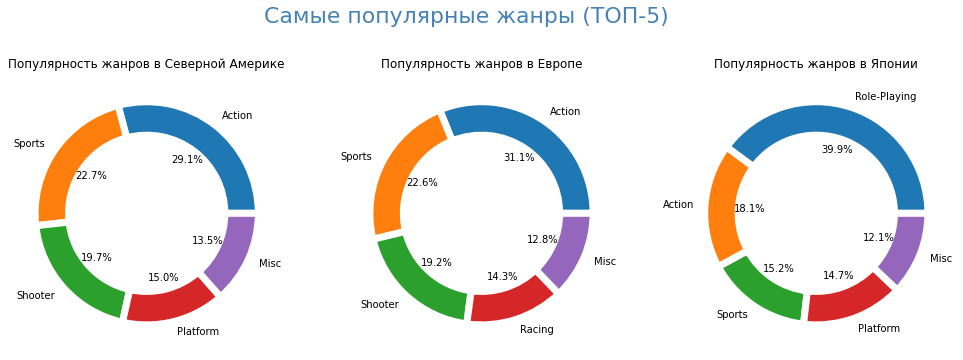

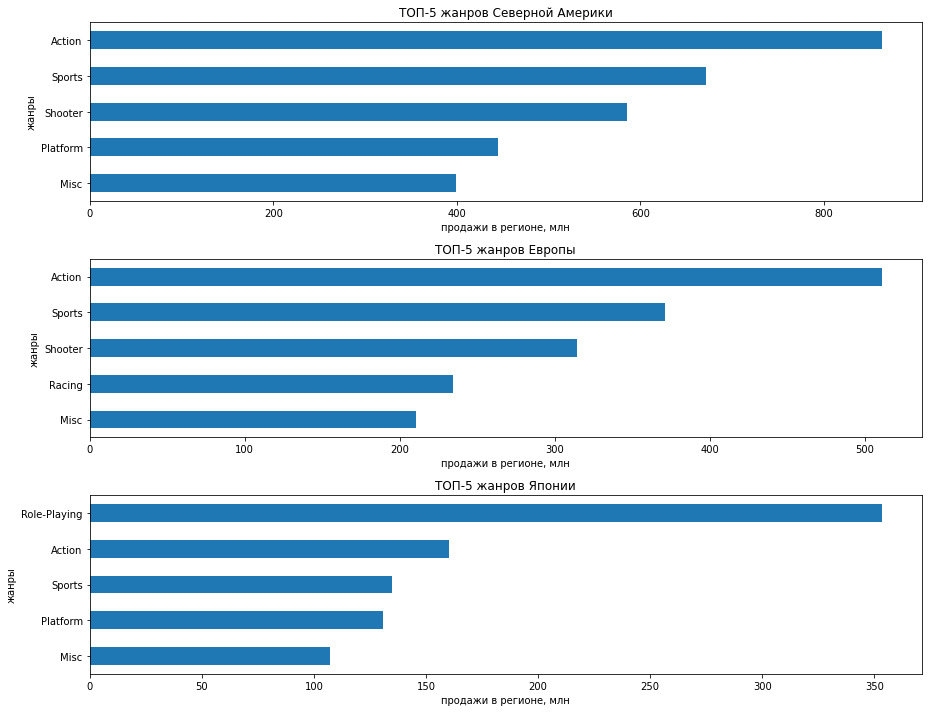

In [155]:
fig, axs = plt.subplots(1, 3, figsize=(17, 6))

fig.suptitle('Самые популярные жанры (ТОП-5)', fontsize = 22, color = 'SteelBlue');

# Create a pieplot
axs[0].pie(na_genre.na_sales, labels=na_genre.index, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3}, autopct='%1.1f%%')
axs[0].set_title('Популярность жанров в Северной Америке')

# Create a pieplot
axs[1].pie(eu_genre.eu_sales, labels=eu_genre.index, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3 }, autopct='%1.1f%%')
axs[1].set_title('Популярность жанров в Европе')

# Create a pieplot
axs[2].pie(jp_genre.jp_sales, labels=jp_genre.index, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3 }, autopct='%1.1f%%')
axs[2].set_title('Популярность жанров в Японии')


fig, axes = plt.subplots(3, 1, figsize=(13,10))

na_genre.sort_values(by='na_sales').plot.barh(legend=False, title='ТОП-5 жанров Северной Америки', ax = axes[0])
axes[0].set_xlabel("продажи в регионе, млн")
axes[0].set_ylabel("жанры");

eu_genre.sort_values(by='eu_sales').plot.barh(legend=False, title='ТОП-5 жанров Европы', ax = axes[1])
axes[1].set_xlabel("продажи в регионе, млн")
axes[1].set_ylabel("жанры");

jp_genre.sort_values(by='jp_sales').plot.barh(legend=False, title='ТОП-5 жанров Японии', ax = axes[2])
axes[2].set_xlabel("продажи в регионе, млн")
axes[2].set_ylabel("жанры");

plt.tight_layout()

In [104]:
print(f"""В регионе NA лидирует рейтинг {na_genre.index[0]} - {round(na_genre['na_sales'][0]/na_genre['na_sales'].sum()*100,1)}%, второе место {na_genre.index[1]} - {round(na_genre['na_sales'][1]/na_genre['na_sales'].sum()*100,1)}%, на 5 месте: {na_genre.index[-1]} - {round(na_genre['na_sales'][-1]/na_genre['na_sales'].sum()*100,1)}% 
В регионе EU лидирует рейтинг {eu_genre.index[0]} - {round(eu_genre['eu_sales'][0]/eu_genre['eu_sales'].sum()*100,1)}%, второе место {eu_genre.index[1]} - {round(eu_genre['eu_sales'][1]/eu_genre['eu_sales'].sum()*100,1)}%, на 5 месте: {eu_genre.index[-1]} - {round(eu_genre['eu_sales'][-1]/eu_genre['eu_sales'].sum()*100,1)}%
В регионе JP лидирует рейтинг {jp_genre.index[0]} - {round(jp_genre['jp_sales'][0]/jp_genre['jp_sales'].sum()*100,1)}%, второе место {jp_genre.index[1]} - {round(jp_genre['jp_sales'][1]/jp_genre['jp_sales'].sum()*100,1)}%, на 5 месте: {jp_genre.index[-1]} - {round(jp_genre['jp_sales'][-1]/jp_genre['jp_sales'].sum()*100,1)}%""") 

В регионе NA лидирует рейтинг Shooter - 32.1%, второе место Action - 29.5%, на 5 месте: Misc - 6.1% 
В регионе EU лидирует рейтинг Action - 32.7%, второе место Shooter - 28.7%, на 5 месте: Racing - 6.2%
В регионе JP лидирует рейтинг Role-Playing - 40.2%, второе место Action - 38.1%, на 5 месте: Shooter - 6.3%


### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

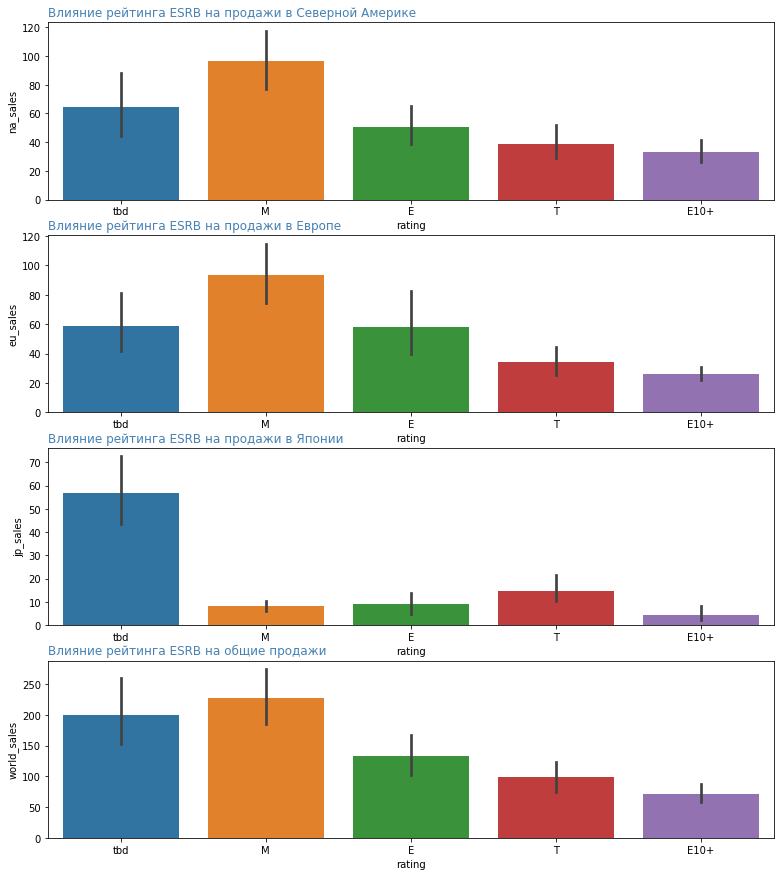

In [143]:
# plot violin chart
fig, axes = plt.subplots(4, 1, squeeze=False, figsize=(13, 15))


sns.barplot(x='rating', y='na_sales', data=data_2014, estimator=sum, ax=axes[0,0])
sns.barplot(x='rating', y='eu_sales', data=data_2014, estimator=sum, ax=axes[1,0])
sns.barplot(x='rating', y='jp_sales', data=data_2014, estimator=sum, ax=axes[2,0])
sns.barplot(x='rating', y='world_sales', data=data_2014, estimator=sum, ax=axes[3,0])

# add title
axes[0,0].set_title("Влияние рейтинга ESRB на продажи в Северной Америке" , loc="left", color = 'SteelBlue');
axes[1,0].set_title("Влияние рейтинга ESRB на продажи в Европе", loc="left", color = 'SteelBlue');
axes[2,0].set_title("Влияние рейтинга ESRB на продажи в Японии", loc="left", color = 'SteelBlue');
axes[3,0].set_title("Влияние рейтинга ESRB на общие продажи", loc="left", color = 'SteelBlue');

# show the graph
plt.show()


In [106]:
na_rating = data_2014.query('na_sales > 0').pivot_table(index='rating', values='na_sales', aggfunc='sum'). \
                                                        sort_values(by='na_sales',ascending=False)
eu_rating = data_2014.query('eu_sales > 0').pivot_table(index='rating', values='eu_sales', aggfunc='sum'). \
                                                        sort_values(by='eu_sales',ascending=False)
jp_rating = data_2014.query('jp_sales > 0').pivot_table(index='rating', values='jp_sales', aggfunc='sum'). \
                                                        sort_values(by='jp_sales',ascending=False)

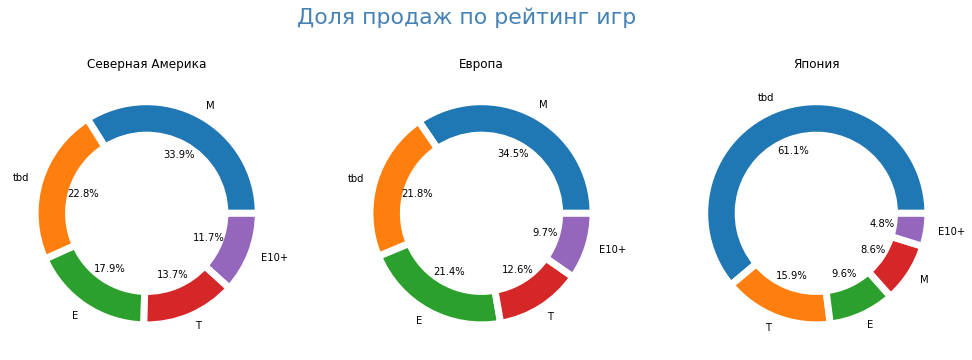

In [145]:
fig, axs = plt.subplots(1, 3, figsize=(17, 6))

fig.suptitle('Доля продаж по рейтинг игр' + "\n", fontsize = 22, color = 'SteelBlue')

# Create a pieplot
axs[0].pie(na_rating.na_sales, labels=na_rating.index, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3}, autopct='%1.1f%%')
axs[0].set_title('Северная Америка')

# Create a pieplot
axs[1].pie(eu_rating.eu_sales, labels=eu_rating.index, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3 }, autopct='%1.1f%%')
axs[1].set_title('Европа')

# Create a pieplot
axs[2].pie(jp_rating.jp_sales, labels=jp_rating.index, \
              wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white', 'width': 0.3 }, autopct='%1.1f%%')
axs[2].set_title('Япония');

In [108]:
print(f"""Рейтинг влияет на объем продаж, причём в северной Америке и Европе поведение схоже, в Японии преобладают продажи игр с
рейтингом tbd (т.к. не актуален для региона Япония), на втором местое T.  
Суммарные значения прожад отражают тенденцию Америке и Европы - Япония вносит небольшую корректировку в данные

В регионе NA лидирует рейтинг {na_rating.index[0]} - {round(na_rating['na_sales'][0]/na_rating['na_sales'].sum()*100,1)}%, второе место {na_rating.index[1]} - {round(na_rating['na_sales'][1]/na_rating['na_sales'].sum()*100,1)}%, на 5 месте: {na_rating.index[-1]} - {round(na_rating['na_sales'][-1]/na_rating['na_sales'].sum()*100,1)}% 
В регионе EU лидирует рейтинг {eu_rating.index[0]} - {round(eu_rating['eu_sales'][0]/eu_rating['eu_sales'].sum()*100,1)}%, второе место {eu_rating.index[1]} - {round(eu_rating['eu_sales'][1]/eu_rating['eu_sales'].sum()*100,1)}%, на 5 месте: {eu_rating.index[-1]} - {round(eu_rating['eu_sales'][-1]/eu_rating['eu_sales'].sum()*100,1)}%
В регионе JP лидирует рейтинг {jp_rating.index[0]} - {round(jp_rating['jp_sales'][0]/jp_rating['jp_sales'].sum()*100,1)}%, второе место {jp_rating.index[1]} - {round(jp_rating['jp_sales'][1]/jp_rating['jp_sales'].sum()*100,1)}%, на 5 месте: {jp_rating.index[-1]} - {round(jp_rating['jp_sales'][-1]/jp_rating['jp_sales'].sum()*100,1)}%

Рейтинги игр влияют на продажи.  
Для Японии преобладают продажи без рейтинга ({round(jp_rating[jp_rating.index=='tbd']['jp_sales'][0]/jp_rating['jp_sales'].sum()*100,1)}% от всех продаж)  
Для Северной Америки доля продаж игр без рейтинга {round(na_rating[na_rating.index=='M']['na_sales'][0]/na_rating['na_sales'].sum()*100,1)}%, для Европы {round(eu_rating[eu_rating.index=='M']['eu_sales'][0]/eu_rating['eu_sales'].sum()*100,1)}%""") 

Рейтинг влияет на объем продаж, причём в северной Америке и Европе поведение схоже, в Японии преобладают продажи игр с
рейтингом tbd (т.к. не актуален для региона Япония), на втором местое T.  
Суммарные значения прожад отражают тенденцию Америке и Европы - Япония вносит небольшую корректировку в данные

В регионе NA лидирует рейтинг M - 33.9%, второе место tbd - 22.8%, на 5 месте: E10+ - 11.7% 
В регионе EU лидирует рейтинг M - 34.5%, второе место tbd - 21.8%, на 5 месте: E10+ - 9.7%
В регионе JP лидирует рейтинг tbd - 61.1%, второе место T - 15.9%, на 5 месте: E10+ - 4.8%

Рейтинги игр влияют на продажи.  
Для Японии преобладают продажи без рейтинга (61.1% от всех продаж)  
Для Северной Америки доля продаж игр без рейтинга 33.9%, для Европы 34.5%


### Вывод:
**ТОП-5 платформ:**  
 - В регионе NA лидирует X360, с долей продаж 24,5%, немного отстаёт PS2 - 23,7%, на 5 месте: DS - 15,6%
 - В регионе EU лидирует PS2, с долей продаж 24%, немного отстаёт PS3 - 23,3%, на 5 месте: PS - 15,1%
 - В регионе JP безоговорочный лидирует DS, с долей продаж 26,1%, немного отстаёт PS - 20,8%, на 5 месте: 3DS - 15,0%

**ТОП-5 жанров:**  
 - В Америке и Евроме преобладает жанр **Action**, 
 - В Японии **Role-Playing**. Связать это можно с тем, что в ТОП-5 входит две портативные консоли, где традиционно преобладают игры жанра РПГ, эти консоли и игры типа Зельды - родились в Японии, и любимы игроками. Для евромейцев и американцев классикой являются экшн-игры
 
**Влияние рейтинга ESRB на продажи**  
Рейтинги игр влияют на продажи.  
Для Японии преобладают продажи без рейтинга (60% от всех продаж)  
Для Северной Америки и Европы доля продаж игр без рейтинга ~ 24%

## Шаг. Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Для первой гипотезы подготовим данные. Отфильтруем данные только для двух платформ, а из рейтинга пользователей уберем "tbd", иначе мы не сможем проверить гипотезу  
Мы выбираем метод для для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: `scipy.stats.ttest_ind(array1, array2, equal_var, alternative)`

In [111]:
data_hyp_1 = data_2014.query('user_score != "tbd" and user_score != 0 and (platform == "XOne" or platform == "PC")')[['platform','user_score']]
data_hyp_1['user_score'] = data_hyp_1['user_score'].astype('float')

 - **Нулевая гипотеза:** рейтинг игр на платформах Xbox One и PC равны
 - **Альтернативная гипотеза:** рейтинг игр на платформах Xbox One и PC НЕ равны

In [112]:
alpha = 0.05 # уровень статистической значимости # если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_hyp_1.query('platform == "XOne"')['user_score'],
                       data_hyp_1.query('platform == "PC"')['user_score'])
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


 Полученное значение p-value говорит о том, что хотя оценки игроков на двух платформах и неодинаковы , с вероятностью 10%  <b>такое или большее различие можно получить случайно </b> Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними оценками пользователей двух платформ

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Мы выбираем метод для для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: `scipy.stats.ttest_ind(array1, array2, equal_var, alternative)`

In [115]:
data_hyp_2 = data_2014.query('user_score != "tbd" and user_score != 0 and (genre == "Action" or genre == "Sports")')[['genre','user_score']]
data_hyp_2['user_score'] = data_hyp_2['user_score'].astype('float')

 - **Нулевая гипотеза:** рейтинг игр в жанре "Action" и "Sports" равны
 - **Альтернативная гипотеза:** рейтинг игр в жанре "Action" и "Sports" не равны

In [117]:
alpha = 0.05 # уровень статистической значимости # если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_hyp_2.query('genre == "Action"')['user_score'],
                       data_hyp_2.query('genre == "Sports"')['user_score'])
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Рейтинг игр в жанре "Action" и "Sports" не равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу.Рейтинг игр в жанре "Action" и "Sports" равны')

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу. Рейтинг игр в жанре "Action" и "Sports" не равны


По-видимому, рейтинги игр в жанрах "Action" и "Sports" не равны. **C вероятностью в 1% рейтинги игр этих жанров могут быть одинаковые.** Это малая вероятность, чтобы делать вывод о равенстве рейтингов жанров.

## Общий вывод

**ПЕРВОЕ:**
- Полученные данные представлены без дубликатов, мы изменили типы данных у параметра года выпуска на целочисленное число.  
- Обработали пропуски в оценках критиков - заменили на 0. 
- Пропуск в оценках пользователей и рейтинге "ESRB" заменили на "tbd" - "To Be Determined" (нет оценки по какой-то причине).  
- Пропуски у парамтера "год выпуска" заменили, или на ноль, или взяли значение из название игры (например, если игра называется FIFA 2006, а год выпуска не определен, мы указывали, что год выхода - 2006). Данные с нулевым годом релиза удалили.
- Так же удалили платформы, с менее одного года продаж
- Название колонок исправили, теперь все надписи в нижнем регистре.  
- Подсчитали суммарные продажи в трёх регинонах, данные добавили в столбец "world_cales"

**ВТОРОЕ:**
- Подсчитали среднее значение выпускаемх игр в год - получилось ~ **447 игры в год**
- Платформа с наибольшими суммарными продажами - **PS2: 1233млн**. Следом X360: 961млн и Wii: 891.65млн
- Проанализировав данные, поняли, что актуальный период для анализа - **2015-2016 года**
- ТОП-3 перспективных платформ: PS4, XOne, WiiU
- WiiU имеет бОльшую связь отзывов и продаж по сравнению с PS4 и XOne
- За актуальны период лучше всего продавались игры в жанре: Shooter, Action, Role-Playing, Sport, Fighting
- Худшие продажи у жанров Strategy, Adventure и Puzzle
- С 2008г наблюдается спад по всем метрикам

**ТРЕТЬЕ:**
- Самые популярные платформы (топ-5):
 - В регионе NA лидирует PS4, с долей продаж 42.1%, вторая платформа XOne - 33.1%, на 5 месте: X360 - 5.3%  
 - В регионе EU лидирует PS4, с долей продаж 56.5%, вторая платформа XOne - 19%, на 5 месте: PS3 - 4.9%  
 - В регионе JP лидирует 3DS, с долей продаж 44.1%, вторая платформа PS4 - 22,6%, на 5 месте: WiiU - 7,7%  
- Самые популярные жанры (топ-5):
 - В регионе NA лидирует Shooter, с долей продаж 36,1%, второе место Action - 25,1%, на 5 месте: Misc - 4,2%  
 - В регионе EU лидирует Shooter, с долей продаж 31,8%, вторая место Action - 27,5%, на 5 месте: Racing - 5,1%  
 - В регионе JP лидирует Action, с долей продаж 50,5%, вторая место Role-Playing - 29,4%, на 5 месте: Adventure - 4,9%  
- Рейтинги игр влияют на продажи.
 - В регионе NA лидирует рейтинг M - 31,0%, второе место tbd - 24,7%, на 5 месте: E10+ - 11,8%  
 - В регионе EU лидирует рейтинг M - 30,8%, второе место tbd - 24,1%, на 5 месте: E10+ - 7,8%  
 - В регионе JP лидирует рейтинг tbd - 61,6%, второе место T - 14,4%, на 5 месте: E10+ - 6,1%
 - Для Японии преобладают продажи без рейтинга (60% от всех продаж)
 - Для Северной Америки и Европы доля продаж игр без рейтинга ~ 24%

**ЧЕТВЕРТОЕ:**
- Средние пользовательские рейтинги платформ Xbox One и PC **равны**
- Средние пользовательские рейтинги игр в жанре "Action" и "Sports" **не равны**